## Data sources

In order to validate the claims from [this](https://www.bloomberg.com/news/articles/2020-05-11/why-chicken-is-plentiful-during-the-pandemic-and-beef-is-not?srnd=premium&utm_medium=social&utm_source=twitter&utm_campaign=socialflow-organic&utm_content=markets&cmpid%3D=socialflow-twitter-markets&sref=XQtHDW1P) article, I pulled price data from FRED (which sources data from the BLS) and adjusted it using the CPI. Data sources are here:

- Poultry 
    - [price](https://fred.stlouisfed.org/series/APU0000706111)
    - [index](https://beta.bls.gov/dataViewer/view/timeseries/CUUR0000SEFF)
- Pork
    - [price](https://fred.stlouisfed.org/series/APU0000FD3101)
    - [index](https://beta.bls.gov/dataViewer/view/timeseries/CUUR0000SEFD)
- Beef
    - [price](https://fred.stlouisfed.org/series/APU0000703112)
    - [index](https://beta.bls.gov/dataViewer/view/timeseries/CUUR0000SEFC)

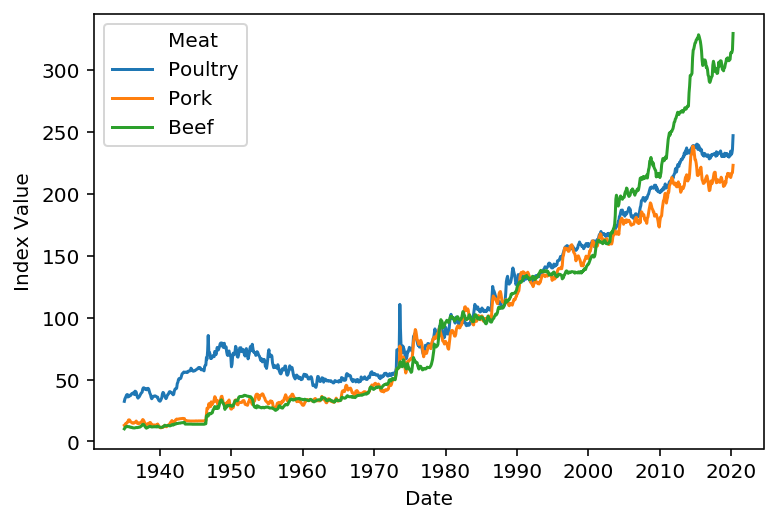

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
from IPython.core.display import HTML

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# https://github.com/jupyter/notebook/issues/3670
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%run ./helpers.ipynb

cpi = (
    pd.read_csv('data/CPIAUCSL.csv')
    .assign(Date = lambda x: pd.to_datetime(x['DATE']))
    .rename(columns={'CPIAUCSL':'cpi'})
    [['Date', 'cpi']]
)

stacked = get_prices()

sns.lineplot(x='Date', y='Value', hue='Meat', data=stacked);
plt.ylabel('Index Value');

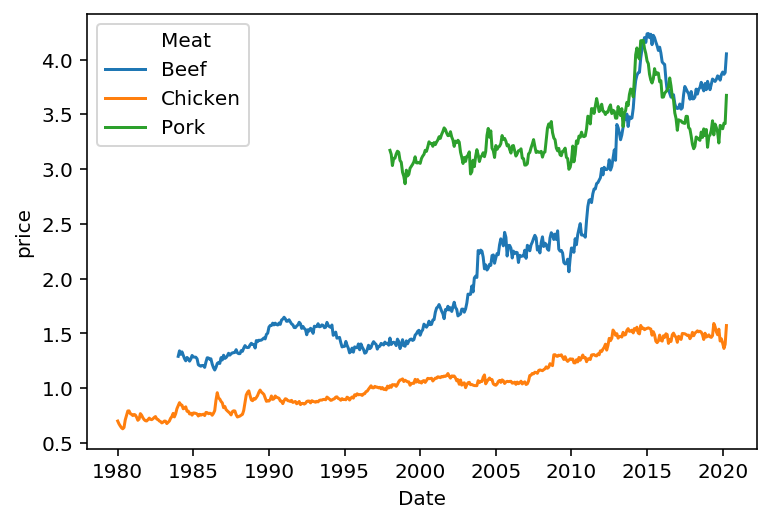

In [11]:
yuh = get_indices()
sns.lineplot(x='Date', y='price', hue='Meat', data=yuh);

In [12]:
yuh.query('Meat == "Pork"').dropna(subset=['price']).sort_values(by=['DATE'])

,DATE,price,Series,Date,Meat
0,1998-01-01,3.171,APU0000FD3101,1998-01-01,Pork
1,1998-02-01,3.134,APU0000FD3101,1998-02-01,Pork
2,1998-03-01,3.032,APU0000FD3101,1998-03-01,Pork
3,1998-04-01,3.098,APU0000FD3101,1998-04-01,Pork
4,1998-05-01,3.099,APU0000FD3101,1998-05-01,Pork
...,...,...,...,...,...
263,2019-12-01,3.391,APU0000FD3101,2019-12-01,Pork
264,2020-01-01,3.368,APU0000FD3101,2020-01-01,Pork
265,2020-02-01,3.419,APU0000FD3101,2020-02-01,Pork
266,2020-03-01,3.415,APU0000FD3101,2020-03-01,Pork


In [13]:
# Find the nominal price at the base year of the index (1982 - 1984)ish for each Meat
(
    yuh.loc[yuh['Date'].apply(lambda x: x.year).isin([1983, 1984])]
    .groupby('Meat')
    .aggregate({'price':np.mean})
)

# Adjust 1935 prices
# Compute pct difference

,price
Meat,
Beef,1.287167
Chicken,0.767375


In [ ]:
#HTML(df.to_html().replace('border="1"','border="0"'))